# Shear wave test case

In [30]:
include("notebook_examples.jl");

# Shear wave decay


In [5]:
snapshot_at = [0.0, 0.05, 0.15, 0.25]
q = D2Q9()
ν_lb = 1.0 / 6.0
Nₓ = 4
problem = DecayingShearFlow(ν_lb, Nₓ, A = 3.0, static = false)


Δt = delta_t(problem);
result = simulate(
    problem,
    q,
    t_end = 0.50 / Δt,
    process_method = LatticeBoltzmann.TakeSnapshots(problem, round.(Int, snapshot_at ./ Δt) .+ 1),
);

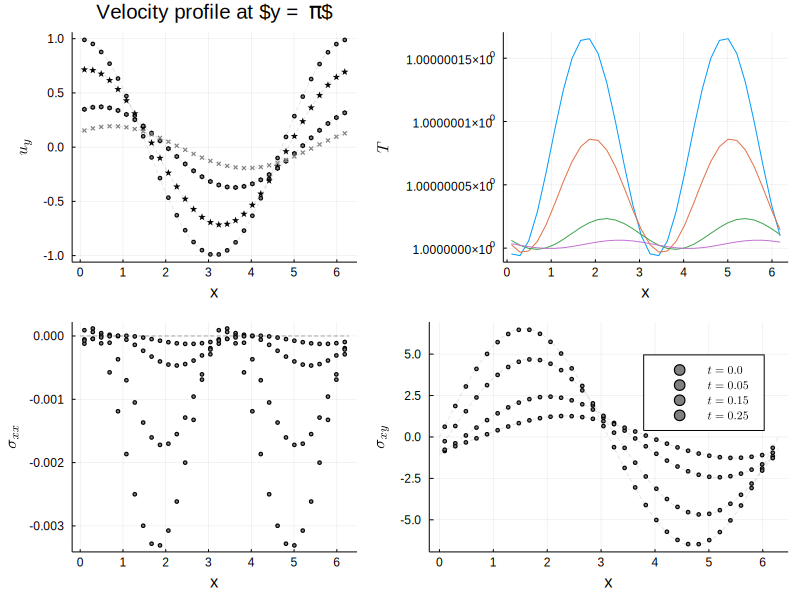

In [6]:
plots = plot_snapshots(problem, result.processing_method.snapshots, snapshot_at, q)

plot(
    plot!(plots.velocity_profile_y, legend = false),
    plot!(plots.temperature_profile, legend = false),
    plot!(plots.sigma_xx_profile, legend = false),
    plots.sigma_xy_profile,
    size=(800, 600),
    markrershape = :diamond,
    markercolor = :gray,
    markersize = 2,
)

# Steady state solution

In [9]:
q = D2Q9()
ν_lb = 1.0 / 6.0
Nₓ = 16
problem = DecayingShearFlow(ν_lb, Nₓ, A = 0.5, static = true)
snapshot_at = [0.01, 0.1, 1.0, 10.0]

ν = LatticeBoltzmann.viscosity(problem)
Δt = delta_t(problem);
result = simulate(
    problem,
    q,
    t_end = 10.0 / LatticeBoltzmann.viscosity(problem),
    process_method = LatticeBoltzmann.TakeSnapshots(problem, round.(Int, snapshot_at ./ (ν * Δt))),
    initialization_strategy = LatticeBoltzmann.ZeroVelocityInitialCondition()
);

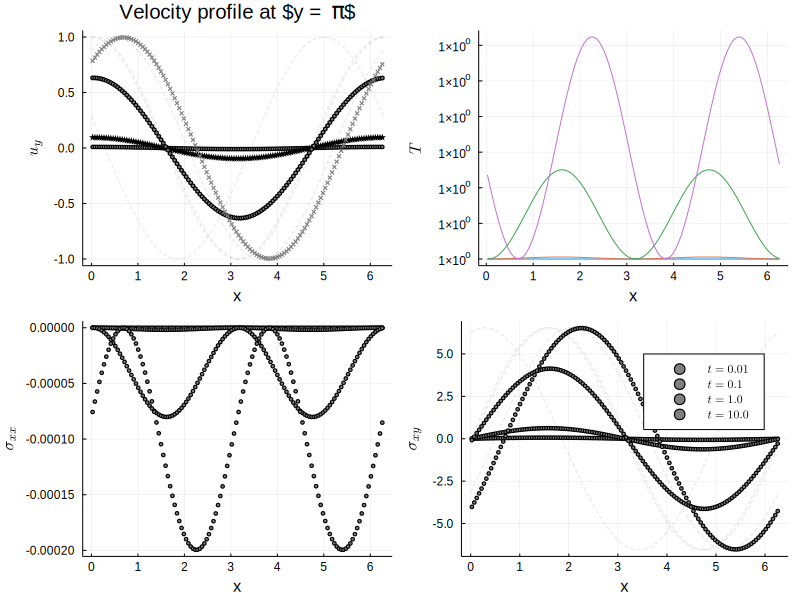

In [10]:
p = LatticeBoltzmann.visualize(result.processing_method, q)
plot!(p.velocity_profile_x, legend = nothing)

plots = plot_snapshots(problem, result.processing_method.snapshots, snapshot_at, q)

plot(
    plot!(plots.velocity_profile_y, legend = false),
    plot!(plots.temperature_profile, legend = false),
    plot!(plots.sigma_xx_profile, legend = false),
    plots.sigma_xy_profile,
    size=(800, 600),
    markrershape = :diamond,
    markercolor = :gray,
    markersize = 2,
)

# Convergence analysis

In [11]:
q = D2Q9()
τ = 0.8
cm = SRT
f₀ = AnalyticalEquilibrium()
scales = [1, 2, 4, 8]
quadratures = LatticeBoltzmann.Quadratures
d2q9_convergence = shear_wave_convergence_analysis(q, f₀, τ, scales = scales);

  0.860853 seconds (1.12 M allocations: 59.341 MiB, 2.75% gc time)
  0.019648 seconds (103.68 k allocations: 6.378 MiB)
  0.152644 seconds (652.62 k allocations: 42.103 MiB)
  1.315148 seconds (4.85 M allocations: 318.162 MiB, 7.95% gc time)


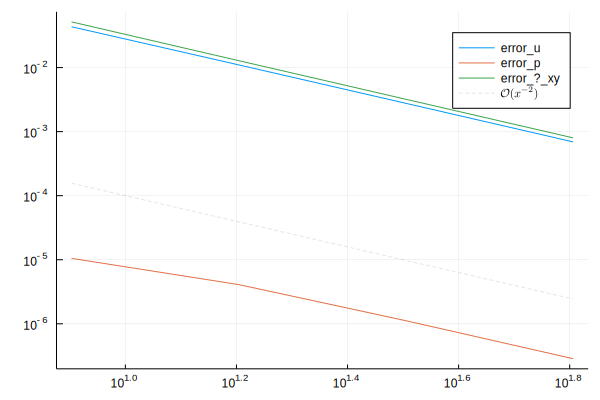

In [12]:
d2q9_convergence
ν_lb = 1.0 / 6.0
problem = DecayingShearFlow(ν_lb, first(d2q9_convergence.scales), static = false)

xs = d2q9_convergence.scales .* problem.NX
p = plot()
foreach([:error_u, :error_p, :error_σ_xy]) do error
    plot!(p, xs, getfield.(d2q9_convergence.results, error), label=string(error))
end
plot!(p, xs, x -> 1E-2 * x.^(-2), label=L"\mathcal{O}(x^{-2})", linecolor = :gray, linealpha = 0.2, linestyle = :dash)
plot(p, scale = :log10)


In [29]:
quadratures = LatticeBoltzmann.Quadratures
convergence_results = map(quadratures) do q
   shear_wave_convergence_analysis(
       q,
       f₀,
       τ,
       scales = scales
   )
end;

  0.002901 seconds (16.84 k allocations: 960.000 KiB)
  0.016494 seconds (89.87 k allocations: 5.568 MiB)
  0.123927 seconds (625.80 k allocations: 40.493 MiB)
  1.061768 seconds (4.80 M allocations: 314.757 MiB, 5.04% gc time)
  0.003317 seconds (17.38 k allocations: 997.797 KiB)
  0.022519 seconds (90.93 k allocations: 5.646 MiB)
  0.180340 seconds (627.92 k allocations: 40.662 MiB, 9.94% gc time)
  1.179554 seconds (4.80 M allocations: 315.157 MiB, 4.72% gc time)
  0.006389 seconds (23.57 k allocations: 1.324 MiB)
  0.029492 seconds (103.29 k allocations: 6.352 MiB)
  0.149722 seconds (652.62 k allocations: 42.103 MiB)
  1.302941 seconds (4.85 M allocations: 318.162 MiB, 4.06% gc time)
  0.004827 seconds (27.34 k allocations: 1.550 MiB)
  0.021994 seconds (110.80 k allocations: 6.809 MiB)
  0.161285 seconds (667.62 k allocations: 43.046 MiB, 7.17% gc time)
  1.460766 seconds (4.88 M allocations: 320.170 MiB, 3.85% gc time)
  0.005749 seconds (34.25 k allocations: 1.952 MiB)
  0.0250

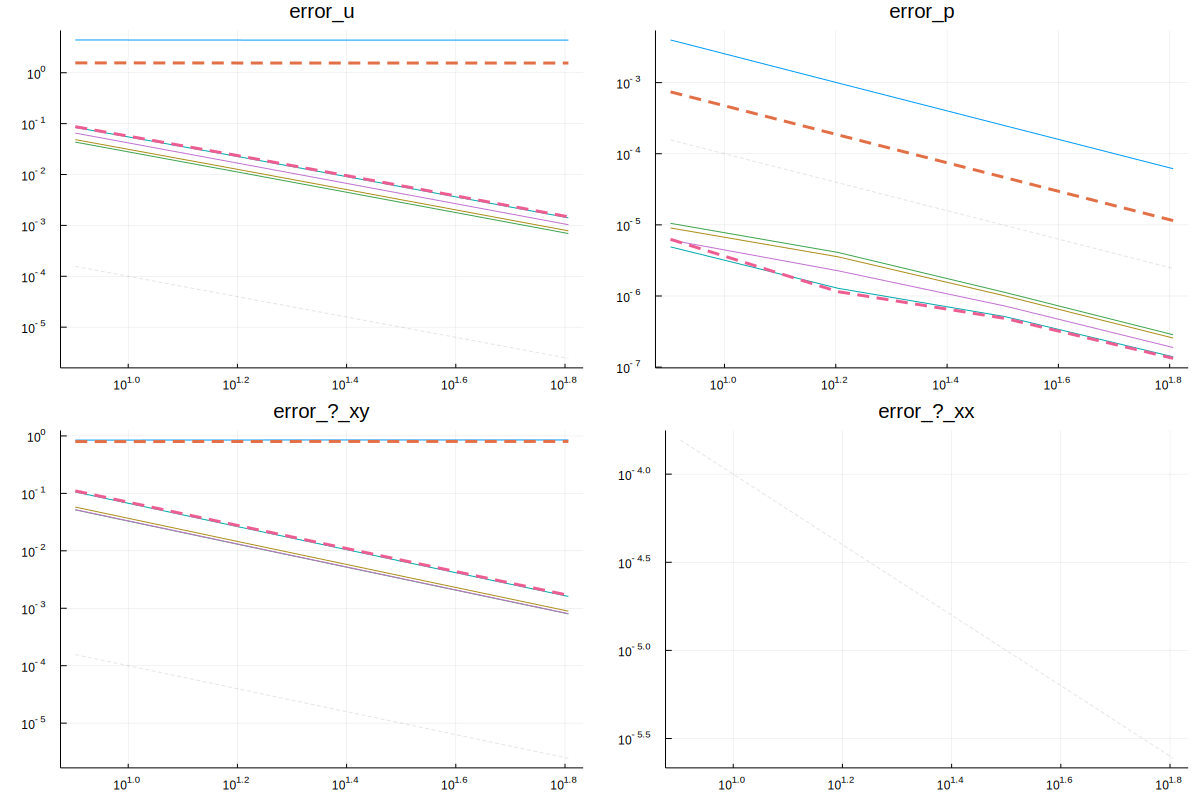

In [28]:
# For each error that we track, show its convergence rate
plots = Dict(
    :error_u => plot(),
    :error_p => plot(),
    :error_σ_xx => plot(),
    :error_σ_xy => plot(),
)
foreach(convergence_results) do result
    ν_lb = 1.0 / 6.0
    problem = DecayingShearFlow(ν_lb, first(result.scales), static = false)
    xs = result.scales .* problem.NX
    foreach(plots) do (error, p)
        plot!(p, xs, getfield.(result.results, error), label=string(result.quadrature), line = line_style(result.quadrature))
    end
end

# Since the diagonal components of σ are all zero we don't have a error measurment,
# so instead use its plot to show the corresponding legend
plot!(plots[:error_σ_xx], legend=:best)

# Add a line as indicator for the convergence
foreach(plots) do (error, p)
    plot!(p, xs, x -> 1E-2 * x.^(-2), label=L"\mathcal{O}(x^{-2})", linecolor = :gray, linealpha = 0.2, linestyle = :dash, scale = :log10, title=string(error), legend=nothing)
end

plot(
    plots[:error_u],
    plots[:error_p],
    plots[:error_σ_xy],
    plots[:error_σ_xx],
    size=(1200, 800)
)
